# Welcome

This notebook shall answer assignment_1b question 2.

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 2: Recursive Feature Elimination](#recursive_feature_elimination)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save Data Objects](#save_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing RFE Feature Space](#eyeballing_rfe_feature_space)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import itertools

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [3]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}
removed_features = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### plot_history_object()

In [4]:
def plot_history_object(histories, model_name, history_object, max=None):   
    if max == None:
        plt.plot(histories[model_name][history_object], label='train_'+history_object)
#         plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    else:
        plt.plot(histories[model_name][history_object][:max], label='train_'+history_object)
#         plt.plot(histories[model_name]['val_'+history_object][:max], label='val_'+history_object)
    plt.ylabel(history_object)
    plt.xlabel('No. epoch')
    plt.legend(loc="center right")
    plt.show()

### histories_saver()

In [5]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename):
    histories_json = {}
    for key in histories.keys():
        histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

# Question 2: Recursive Feature Elimination  <a name="recursive_feature_elimination"></a>
[Back to top](#toc)

<i>Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. Start by removing one input feature that causes the minimum drop (or maximum improvement) in performance. Repeat the procedure
recursively on the reduced input set until the optimal number of input features is reached. Remove the features one at a time. Compare the accuracy of the model with all input features, with models using 6 input features and 5 input features selected using RFE. Comment on the observations.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

In [6]:
num_neurons = 10

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)

optimizer = 'sgd'
loss = keras.losses.MeanSquaredError()
metrics = ['mse']

epochs = 40 # from assignment_1b_q1
learning_rate = 10e-3
batch_size = 8

# callbacks = [TqdmCallback(verbose=1)]
# callbacks = [TqdmCallback(verbose=1), tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [7]:
def create_model(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization, bias_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [8]:
X_feature_list_mapping = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']
X_feature_list = ['f1','f2','f3','f4','f5','f6','f7']
Y_feature_list = ['Chance of Admit']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')

df_X_train = pd.DataFrame(X_train, columns=[X_feature_list])
df_X_test = pd.DataFrame(X_test, columns=[X_feature_list])
df_Y_train = pd.DataFrame(Y_train, columns=[Y_feature_list])
df_Y_test = pd.DataFrame(Y_test, columns=[Y_feature_list])

In [9]:
def RFE(X_feature_list, df_X_train, df_Y_train):
    if len(X_feature_list) == 1:
        return

    most_redundant_feature = ''
    lowest_mse = -1  
    str_X_feature_list = '_'.join(X_feature_list)

    if len(X_feature_list) == 7:
        model = create_model(num_neurons, regularization, optimizer, loss, metrics)

        callbacks = [TqdmCallback(verbose=1)]
        model_name = str_X_feature_list + '_baseline'

        print("using full data, length 7")
        
        histories[model_name] = model.fit(df_X_train, df_Y_train,
                                            epochs=epochs,
                                            verbose = 0,
                                            batch_size=batch_size,
                                            callbacks=callbacks)

        removed_features[model_name] = {'most_redundant_feature': 'None', 'lowest_mse': histories[model_name].history['mse'][-1]}
        print("removed feature: None", )

    
    for feature in X_feature_list:
        model = create_model(num_neurons, regularization, optimizer, loss, metrics)

        callbacks = [TqdmCallback(verbose=1)]
        model_name = str_X_feature_list + '_drop_' + str(feature)

        print("length of truncated dataframe: ", len(df_X_train.copy().drop(columns=[feature]).columns))
        
        histories[model_name] = model.fit(df_X_train.copy().drop(columns=[feature]), df_Y_train,
                                            epochs=epochs,
                                            verbose = 0,
                                            batch_size=batch_size,
                                            callbacks=callbacks)
        if lowest_mse == -1:
            lowest_mse = histories[model_name].history['mse'][-1]
            most_redundant_feature = feature 
        else:
            if histories[model_name].history['mse'][-1] < lowest_mse:
                lowest_mse = histories[model_name].history['mse'][-1]
                most_redundant_feature = feature 

    removed_features[str_X_feature_list] = {'most_redundant_feature': most_redundant_feature, 'lowest_mse': lowest_mse}
    print("removed feature: ", most_redundant_feature)

    
    new_X_feature_list = X_feature_list.copy()
    new_X_feature_list.remove(most_redundant_feature)

    RFE( new_X_feature_list, 
            df_X_train.copy().drop(columns=[most_redundant_feature]),
            df_Y_train)

In [10]:
RFE(X_feature_list, df_X_train, df_Y_train)

Model created


using full data, length 7

removed feature: None
Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

Model created


length of truncated dataframe:  6

removed feature:  f5
Model created


length of truncated dataframe:  5

Model created


length of truncated dataframe:  5

Model created


length of truncated dataframe:  5

Model created


length of truncated dataframe:  5

Model created


length of truncated dataframe:  5

Model created


length of truncated dataframe:  5

removed feature:  f3
Model created


length of truncated dataframe:  4

Model created


length of truncated dataframe:  4

Model created


length of truncated dataframe:  4

Model created


length of truncated dataframe:  4

Model created


length of truncated dataframe:  4

removed feature:  f2
Model created


length of truncated dataframe:  3

Model created


length of truncated dataframe:  3

Model created


length of truncated dataframe:  3

Model created


length of truncated dataframe:  3

removed feature:  f1
Model created


length of truncated dataframe:  2

Model created


length of truncated dataframe:  2

Model created


length of truncated dataframe:  2

removed feature:  f7
Model created


length of truncated dataframe:  1

Model created


length of truncated dataframe:  1

removed feature:  f4


### Save Data Objects <a name="save_data_objects"></a> 
[Back to top](#toc)

In [13]:
histories_saver(histories, "data/histories_q2.json")

Histories saved


In [14]:
with open('data/removed_features_q2.json', 'w') as file:
    json.dump(removed_features, file)
print('removed_features saved')

removed_features saved


In [15]:
with open('data/histories_q2.json') as json_file:
    histories = json.load(json_file)
print('histories reloaded')

histories reloaded


In [16]:
with open('data/removed_features_q2.json') as json_file:
    removed_features = json.load(json_file)
print('removed_features reloaded')

removed_features reloaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

f1_f2_f3_f4_f5_f6_f7_baseline


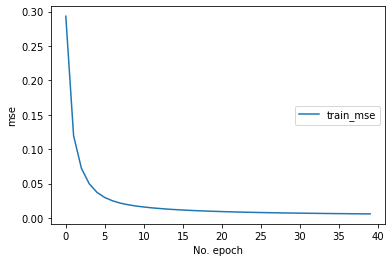

f1_f2_f3_f4_f5_f6_f7_drop_f1


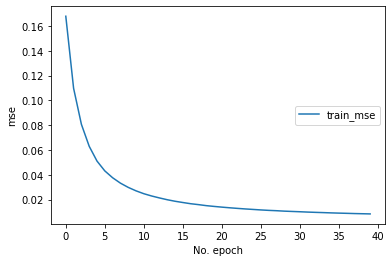

f1_f2_f3_f4_f5_f6_f7_drop_f2


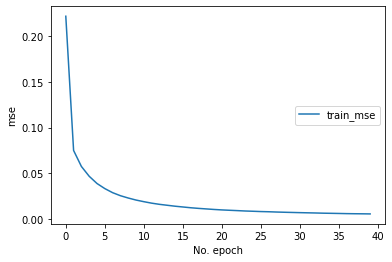

f1_f2_f3_f4_f5_f6_f7_drop_f3


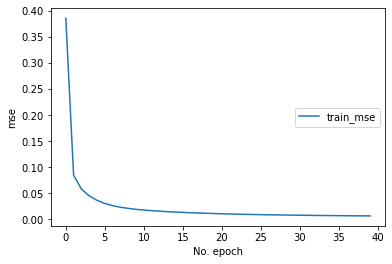

f1_f2_f3_f4_f5_f6_f7_drop_f4


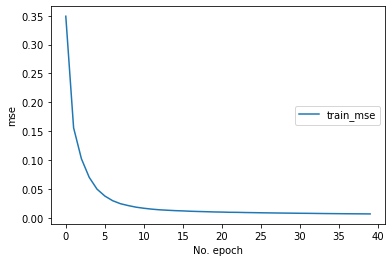

f1_f2_f3_f4_f5_f6_f7_drop_f5


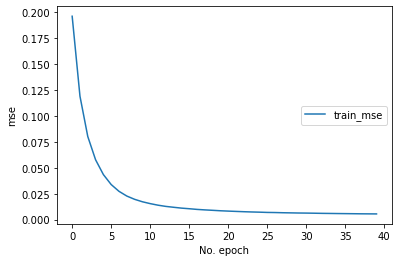

f1_f2_f3_f4_f5_f6_f7_drop_f6


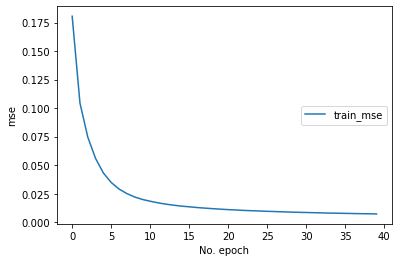

f1_f2_f3_f4_f5_f6_f7_drop_f7


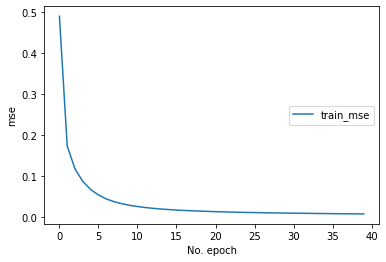

f1_f2_f3_f4_f6_f7_drop_f1


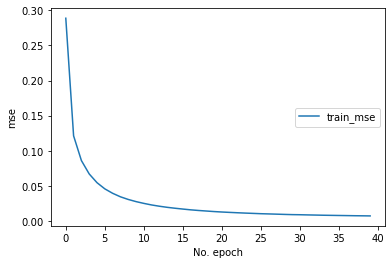

f1_f2_f3_f4_f6_f7_drop_f2


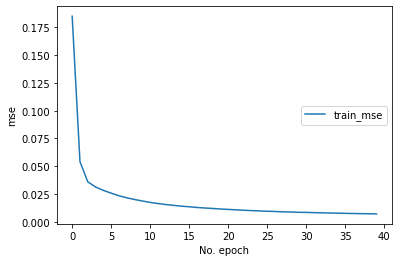

f1_f2_f3_f4_f6_f7_drop_f3


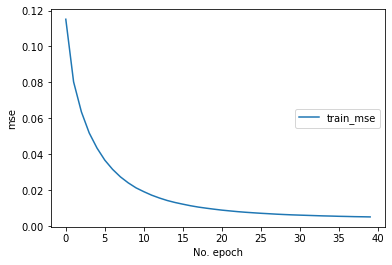

f1_f2_f3_f4_f6_f7_drop_f4


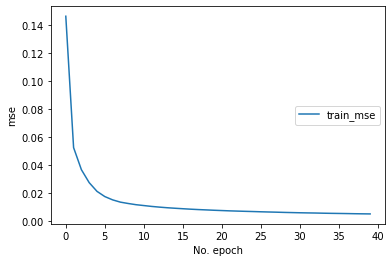

f1_f2_f3_f4_f6_f7_drop_f6


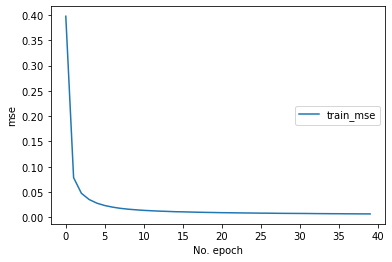

f1_f2_f3_f4_f6_f7_drop_f7


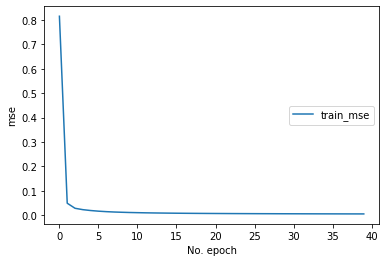

f1_f2_f4_f6_f7_drop_f1


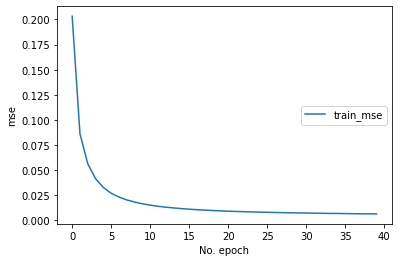

f1_f2_f4_f6_f7_drop_f2


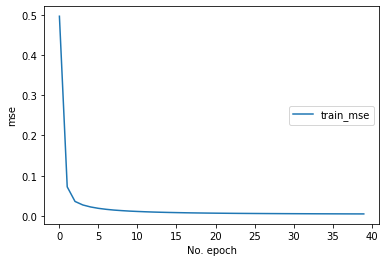

f1_f2_f4_f6_f7_drop_f4


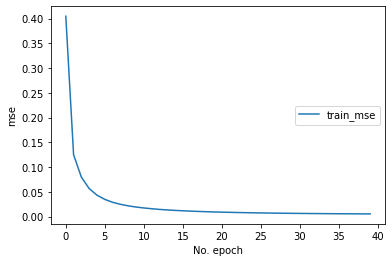

f1_f2_f4_f6_f7_drop_f6


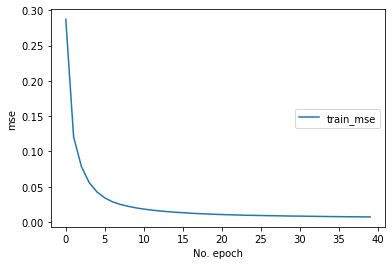

f1_f2_f4_f6_f7_drop_f7


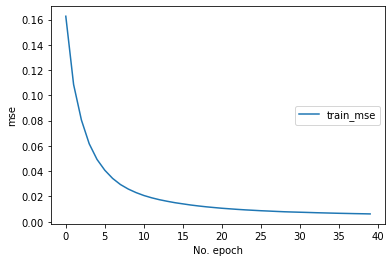

f1_f4_f6_f7_drop_f1


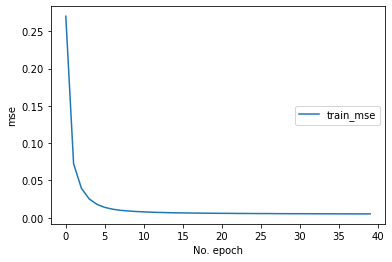

f1_f4_f6_f7_drop_f4


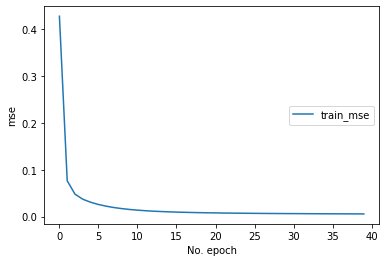

f1_f4_f6_f7_drop_f6


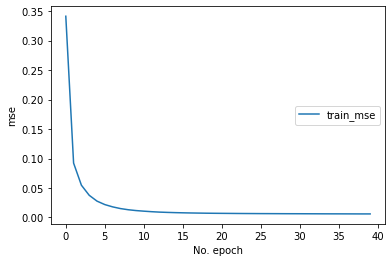

f1_f4_f6_f7_drop_f7


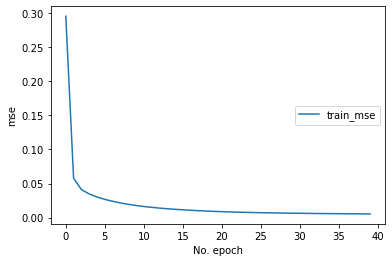

f4_f6_f7_drop_f4


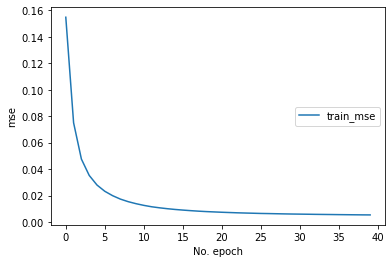

f4_f6_f7_drop_f6


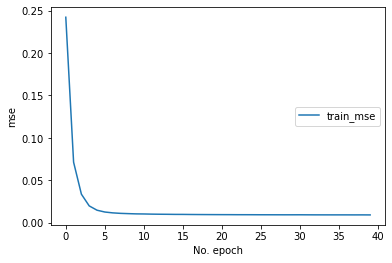

f4_f6_f7_drop_f7


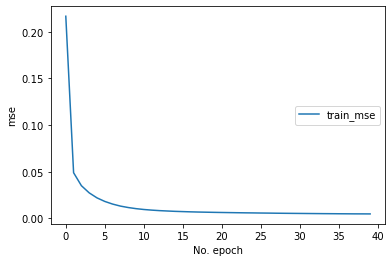

f4_f6_drop_f4


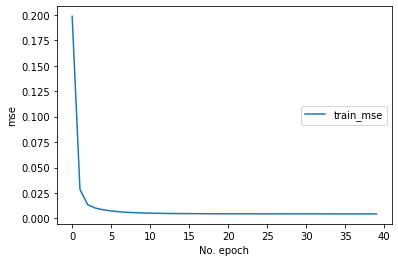

f4_f6_drop_f6


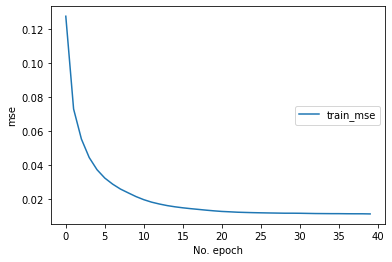

In [17]:
for model_name in histories.keys():
    print(model_name)
    plot_history_object(histories, model_name, 'mse')

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

In [12]:
removed_features

{'f1_f2_f3_f4_f5_f6_f7_baseline': {'most_redundant_feature': 'None',
  'lowest_mse': 0.006042525637894869},
 'f1_f2_f3_f4_f5_f6_f7': {'most_redundant_feature': 'f5',
  'lowest_mse': 0.005458312574774027},
 'f1_f2_f3_f4_f6_f7': {'most_redundant_feature': 'f3',
  'lowest_mse': 0.0050569684244692326},
 'f1_f2_f4_f6_f7': {'most_redundant_feature': 'f2',
  'lowest_mse': 0.004938377067446709},
 'f1_f4_f6_f7': {'most_redundant_feature': 'f1',
  'lowest_mse': 0.00507701002061367},
 'f4_f6_f7': {'most_redundant_feature': 'f7',
  'lowest_mse': 0.004901255946606398},
 'f4_f6': {'most_redundant_feature': 'f4', 'lowest_mse': 0.004431672394275665}}

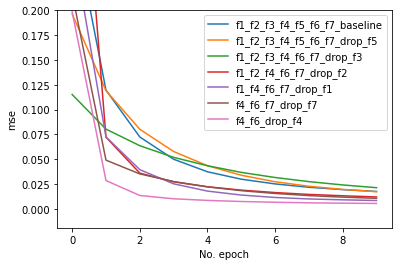

In [54]:
for model_name in [
        'f1_f2_f3_f4_f5_f6_f7_baseline', 
        'f1_f2_f3_f4_f5_f6_f7_drop_f5',
        'f1_f2_f3_f4_f6_f7_drop_f3',
        'f1_f2_f4_f6_f7_drop_f2',
        'f1_f4_f6_f7_drop_f1',
        'f4_f6_f7_drop_f7',
        'f4_f6_drop_f4'
        ]:
    
    plt.plot(histories[model_name]['mse'][:10], label=model_name)

plt.ylim(top=0.2)
plt.ylabel('mse')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

### Eyeballing RFE Feature Space <a name="eyeballing_rfe_feature_space"></a> 
[Back to top](#toc)
    
We shall use the mse that we got from the ```removed_features``` dictionary to determine the best model. We are looking for the <b>lowest mse</b> 


```
{
    'f1_f2_f3_f4_f5_f6_f7_baseline': 
        {'most_redundant_feature': 'None', 'lowest_mse': 0.006042525637894869},
    'f1_f2_f3_f4_f5_f6_f7': 
        {'most_redundant_feature': 'f5', 'lowest_mse': 0.005458312574774027},
    'f1_f2_f3_f4_f6_f7': 
        {'most_redundant_feature': 'f3', 'lowest_mse': 0.0050569684244692326},
    'f1_f2_f4_f6_f7': 
        {'most_redundant_feature': 'f2', 'lowest_mse': 0.004938377067446709},
    'f1_f4_f6_f7': 
        {'most_redundant_feature': 'f1', 'lowest_mse': 0.00507701002061367},
    'f4_f6_f7': 
        {'most_redundant_feature': 'f7', 'lowest_mse': 0.004901255946606398},
    'f4_f6': 
        {'most_redundant_feature': 'f4', 'lowest_mse': 0.004431672394275665}
}
```

We can see that the lowest mse (0.004431672394275665) belongs to the model where f4 was removed from the feature space of f4_f6. This therefore means that the entire X_train had only one feature left, which is f6

Checking against the mapping of actual feature names to f1-f7, we see that f6 corresponds to the feature ```CGPA```, and this also makes perfect sense as we can logically understand that CGPA will play the biggest role in securing a spot in a Masters' program. 

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> Optimal feature space is achieved with the ```CGPA``` feature alone

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use a truncated ```X_test``` to check the performance of the model on the test set, by only using the ```CGPA``` column

In [34]:
df_X_train_truncated = df_X_train[['f6']]
df_X_test_truncated = df_X_test[['f6']]

print(df_X_train_truncated.head())
print(df_X_test_truncated.head())

         f6
0  1.756938
1  1.657227
2  0.211412
3  0.876154
4  1.923123
         f6
0 -0.652753
1  0.128319
2 -0.902032
3 -1.583393
4 -1.998857


In [35]:
test_histories = {}

model = create_model(num_neurons, regularization, optimizer, loss, metrics)

callbacks = [TqdmCallback(verbose=1)]
model_name = 'test_set'

test_histories[model_name] = model.fit(df_X_train_truncated, Y_train,
                                        epochs=epochs,
                                        verbose = 0,
                                        batch_size=batch_size,
                                        callbacks=callbacks)

Model created


In [38]:
Y_test_pred = model.predict(df_X_test_truncated)
Y_test_pred = Y_test_pred.reshape(1,120)[0]

In [39]:
df_Y_test_pred = pd.DataFrame(Y_test_pred, columns =['Y_test_pred']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred, df_Y_test], axis=1)

In [40]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred,Y_test
45,0.715212,0.77
79,0.513279,0.44
56,0.759086,0.75
85,0.671584,0.62
99,0.584499,0.50


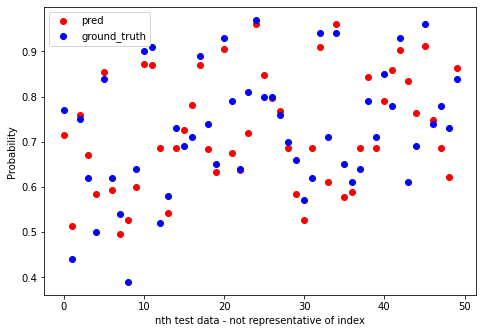

In [41]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred'], color='r', label='pred')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='b', label='ground_truth')

ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
# ax.set_title('scatter plot')
plt.show()

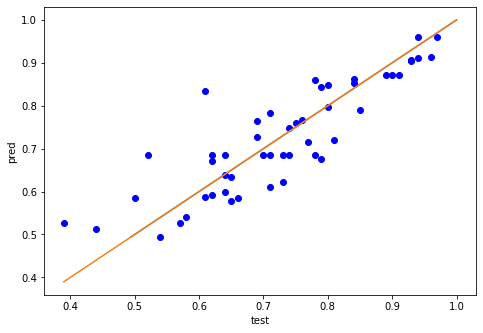

In [42]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred'], color='b')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))
ax.set_xlabel('test')
ax.set_ylabel('pred')
# ax.set_title('scatter plot')
plt.show()